# Loan Default Risk

In [153]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.ensemble import VotingClassifier
from joblib import dump, load

In [154]:
def plot_var(col_name, title, continuous, dataset, x1limit=False, x2limit=False, x1l=0, x1u=0, x2l=0, x2u=0):
    """
    Plot a variable against the response variable loan status
    - col_name is the variable name in the dataframe
    - title is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    - dataset is the pandas dataframe containing the dataset
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)

    # Plot without loan status
    if continuous:
        sns.distplot(dataset.loc[dataset[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(dataset[col_name], order=sorted(dataset[col_name].unique()), color='#4f81bd', saturation=1, ax=ax1)
    if x1limit:
        ax1.set_xlim([x1l, x1u])
    ax1.set_xlabel(title)
    ax1.set_ylabel('Frequency')
    ax1.set_title(title)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=dataset, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(title + ' by Loan Status')
    else:
        charge_off_rates = dataset.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#4f81bd', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + title)
    if x2limit:
        ax2.set_xlim([x2l, x2u])
    ax2.set_xlabel(title)

    plt.tight_layout()


# Preliminary Data Analysis

In [200]:
# read in the entire raw dataset
dataset = pd.read_csv(Path('../data/Loan Data 2017Q2 Clean.csv'), header=0)
pd.set_option('display.max_columns', None)
dataset.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000,36 months,7.35%,155.19,A,5 years,MORTGAGE,60000.0,Not Verified,Fully Paid,car,15.76,0,Oct-04,12,0,3697,13.20%,25,w,Individual,1,0
1,7500,36 months,7.35%,232.79,A,7 years,MORTGAGE,110000.0,Not Verified,Fully Paid,debt_consolidation,13.12,0,Mar-13,19,0,23348,27.20%,27,w,Individual,4,0
2,9600,36 months,7.97%,300.70,A,< 1 year,OWN,140000.0,Not Verified,Fully Paid,credit_card,18.34,0,Aug-05,16,0,11808,48.60%,44,w,Individual,3,0
3,2000,36 months,7.07%,61.82,A,2 years,RENT,80000.0,Not Verified,Fully Paid,medical,12.15,0,Apr-05,9,0,38,0.30%,12,w,Individual,0,0
4,7200,36 months,24.85%,285.70,E,2 years,RENT,50000.0,Source Verified,Fully Paid,debt_consolidation,6.07,0,Jan-00,4,0,3560,98.90%,5,w,Individual,0,0


In [156]:
# Look at how many of each response variable we have
print(dataset['loan_status'].value_counts(dropna=False))
print(dataset['loan_status'].value_counts(normalize=True, dropna=False))
print(dataset.shape)

Fully Paid     29145
Charged Off    18339
Name: loan_status, dtype: int64
Fully Paid     0.613786
Charged Off    0.386214
Name: loan_status, dtype: float64
(47484, 23)


| Status     | Count | Percentage |
| -----------|:-----:|:----------:|
| Fully Paid | 29145 | 77% |
| Charged Off | 8625 | 23% |

37770 rows x 23 Columns

A list of percentage of missing values in a column

In [157]:
missing_values = ((dataset.isna().sum()) / len(dataset.index)).sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values

emp_length    0.072130
revol_util    0.000653
dti           0.000569
dtype: float64

In [158]:
# Look at the data type of each column
print(dataset.dtypes)

loan_amnt                 int64
term                     object
int_rate                 object
installment             float64
grade                    object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
dti                     float64
delinq_2yrs               int64
earliest_cr_line         object
open_acc                  int64
pub_rec                   int64
revol_bal                 int64
revol_util               object
total_acc                 int64
initial_list_status      object
application_type         object
mort_acc                  int64
pub_rec_bankruptcies      int64
dtype: object


| Variable | Type |
| ---------|:----:|
| Loan Amount | Numerical |
| Term | Categorical |
| Interest Rate | Numerical |
| Installment | Numerical |
| Grade | Categorical |
| Employment Length | Categorical |
| Home Ownership | Categorical |
| Annual Income | Numerical |
| Verification Status | Categorical |
| Loan Status| Categorical |
| Purpose | Categorical |
| Debt-to-Income Ratio | Numerical |
| Delinquency | Categorical |
| Earliest Credit Line | Numerical |
| Open Accounts | Numerical |
| Public Records | Categorical |
| Revolving Balance | Numerical |
| Revolving Utility | Numerical |
| Total Account | Numerical |
| Initial List Status | Categorical |
| Application Type | Categorical |
| Mortage Account | Numerical |
| Public Record of Bankruptcies | Categorical |

# Exploratory Data Analysis

### Annual Income (Numerical)
The self-reported annual income provided by the borrower during registration

               count          mean           std  min      25%      50%  \
loan_status                                                               
Charged Off  18339.0  74087.964528  46859.383886  0.0  45000.0  64000.0   
Fully Paid   29145.0  80899.315013  69096.968024  0.0  49000.0  69000.0   

                 75%        max  
loan_status                      
Charged Off  90000.0   982000.0  
Fully Paid   97133.0  5616890.0  
               count       mean       std  min        25%        50%  \
loan_status                                                            
Charged Off  18339.0  11.058315  0.590915  0.0  10.714440  11.066654   
Fully Paid   29145.0  11.129532  0.625351  0.0  10.799596  11.141876   

                   75%        max  
loan_status                        
Charged Off  11.407576  13.797348  
Fully Paid   11.483847  15.541289  


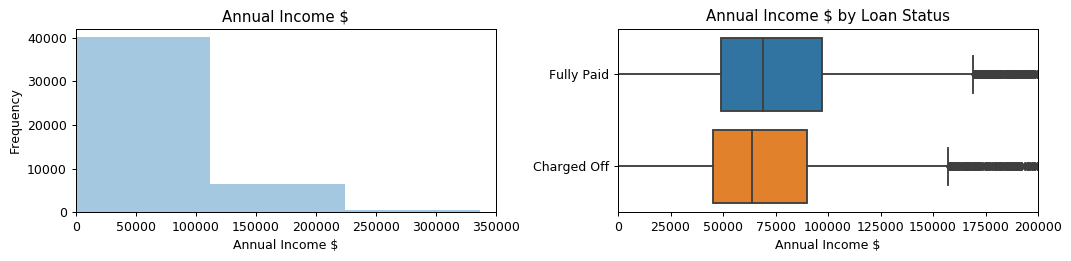

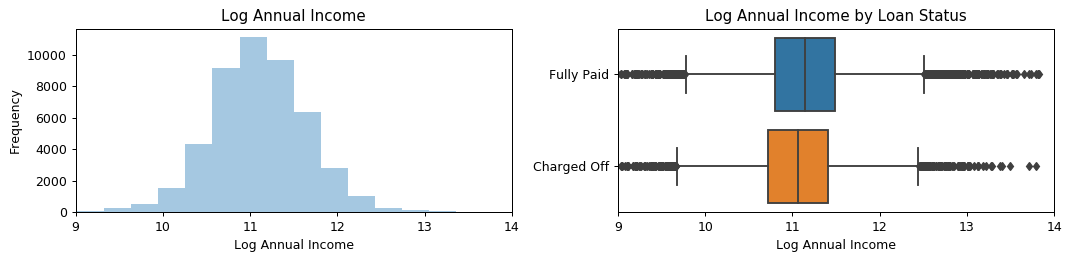

In [159]:
print(dataset.groupby('loan_status')['annual_inc'].describe())
plot_var('annual_inc', 'Annual Income $', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=-1, x1u=350000, x2l=-1, x2u=200000)
# Because the plot is right skewed we take a log transform of the annual income
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log(x + 1))
dataset.drop('annual_inc', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_annual_inc'].describe())
plot_var('log_annual_inc', 'Log Annual Income', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=9, x1u=14, x2l=9, x2u=14)

It seems that those with higher annual income are less risk

### Application Type (Categorical)
Indicates whether the loan is an individual application or a joint application with two co-borrowers

loan_status  application_type
Charged Off  Individual          17399
             Joint App             940
Fully Paid   Individual          27609
             Joint App            1536
Name: application_type, dtype: int64


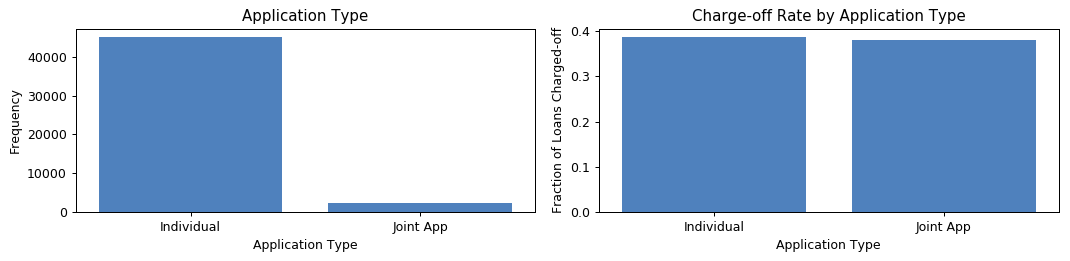

In [160]:
print(dataset.groupby('loan_status')['application_type'].value_counts(dropna=False))
plot_var('application_type', 'Application Type', continuous=False, dataset=dataset)

There does not seem to be a strong correlation between risk and application_type. Both risk around the same percentage.

### Debt to Income Ratio (Numerical)
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

               count       mean        std  min    25%    50%     75%     max
loan_status                                                                  
Charged Off  18331.0  20.361772  12.959714  0.0  13.79  19.99  26.335  886.77
Fully Paid   29126.0  18.066659  13.751295  0.0  11.48  17.19  23.520  999.00


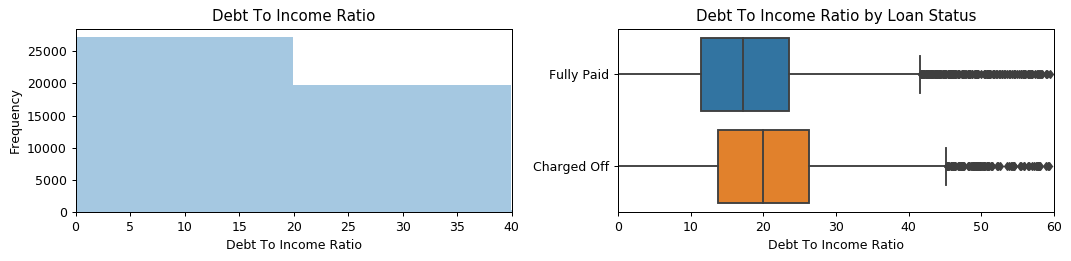

In [161]:
# dummy = dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti']
print(dataset.groupby('loan_status')['dti'].describe())
plot_var('dti', 'Debt To Income Ratio', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=60)
# sns.distplot(dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti'], kde=False)
# plt.xlabel('Debt-to-income Ratio')
# plt.ylabel('Count')
# plt.title('Debt-to-income Ratio')

It seems that a higher debt to income ratio has a higher probability of charged off

### Delinquency (Categorical)
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

loan_status  delinq_2yrs
Charged Off  0              14342
             1               2567
             2               1430
Fully Paid   0              23444
             1               3817
             2               1884
Name: delinq_2yrs, dtype: int64


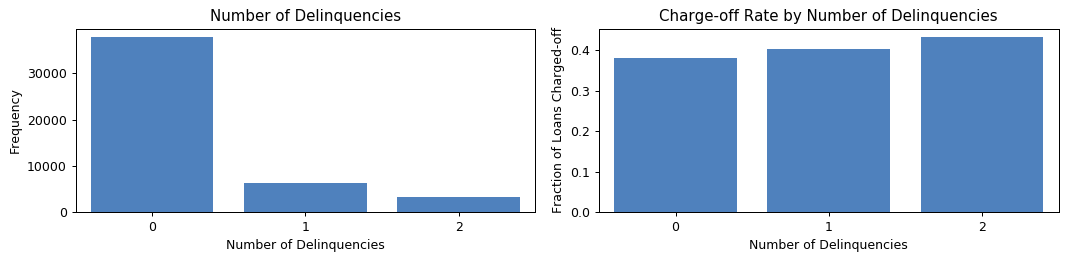

In [162]:
dataset['delinq_2yrs'].values[dataset['delinq_2yrs'] > 1] = 2
print(dataset.groupby('loan_status')['delinq_2yrs'].value_counts(dropna=False))
plot_var('delinq_2yrs', 'Number of Delinquencies', continuous=False, dataset=dataset)

There seems to be an increasing trend in charge-off rate and increasing number of delinquencies but it is small. Whether or not this is significant remains to be seen.

### Earliest Credit Line (Numerical)
The month the borrower's earliest reported credit line was opened.

               count         mean       std     min     25%     50%     75%  \
loan_status                                                                   
Charged Off  18339.0  2000.785975  7.766795  1953.0  1997.0  2002.0  2006.0   
Fully Paid   29145.0  2000.470647  7.565745  1958.0  1997.0  2002.0  2005.0   

                max  
loan_status          
Charged Off  2014.0  
Fully Paid   2014.0  


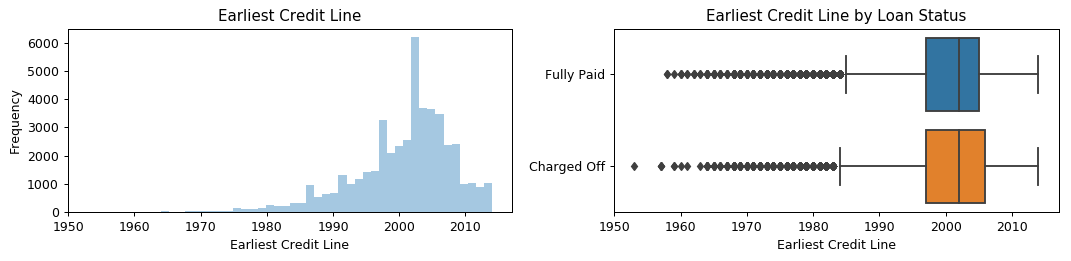

In [163]:
# dataset['earliest_cr_line'] = pd.to_datetime(dataset['earliest_cr_line'], format='%b-%y').dt.year
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-2:]))
dataset.loc[dataset['earliest_cr_line'] > 20, 'earliest_cr_line'] += 1900
dataset.loc[dataset['earliest_cr_line'] < 20, 'earliest_cr_line'] += 2000
print(dataset.groupby('loan_status')['earliest_cr_line'].describe())
plot_var('earliest_cr_line', 'Earliest Credit Line', continuous=True, dataset=dataset)

It seems that those with an earlier credit line are more likely to be less risk

### Employment Length (Categorical)
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

loan_status  emp_length
Charged Off  0.0            1528
             1.0            1321
             2.0            1802
             3.0            1573
             4.0            1093
             5.0            1141
             6.0             725
             7.0             641
             8.0             575
             9.0             624
             10.0           5584
             NaN            1732
Fully Paid   0.0            2454
             1.0            1879
             2.0            2654
             3.0            2349
             4.0            1793
             5.0            1788
             6.0            1311
             7.0            1054
             8.0             856
             9.0            1101
             10.0          10213
             NaN            1693
Name: emp_length, dtype: int64


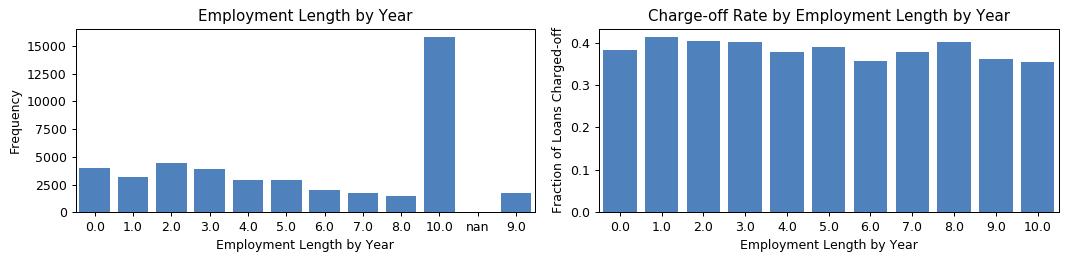

In [164]:
dataset['emp_length'].replace('< 1 year', 0, inplace=True)
dataset['emp_length'].replace('1 year', 1, inplace=True)
dataset['emp_length'].replace('2 years', 2, inplace=True)
dataset['emp_length'].replace('3 years', 3, inplace=True)
dataset['emp_length'].replace('4 years', 4, inplace=True)
dataset['emp_length'].replace('5 years', 5, inplace=True)
dataset['emp_length'].replace('6 years', 6, inplace=True)
dataset['emp_length'].replace('7 years', 7, inplace=True)
dataset['emp_length'].replace('8 years', 8, inplace=True)
dataset['emp_length'].replace('9 years', 9, inplace=True)
dataset['emp_length'].replace('10+ years', 10, inplace=True)
print(dataset.groupby('loan_status')['emp_length'].value_counts(dropna=False).sort_index())
plot_var('emp_length', 'Employment Length by Year', continuous=False, dataset=dataset)

Doesn't seem to be much of a significant pattern here

### Home Ownership (Categorical)
The home ownership status provided by the borrower during registration or obtained from the credit report.

loan_status  home_ownership
Charged Off  RENT               8406
             MORTGAGE           7732
             OWN                2201
Fully Paid   MORTGAGE          15651
             RENT              10149
             OWN                3345
Name: home_ownership, dtype: int64


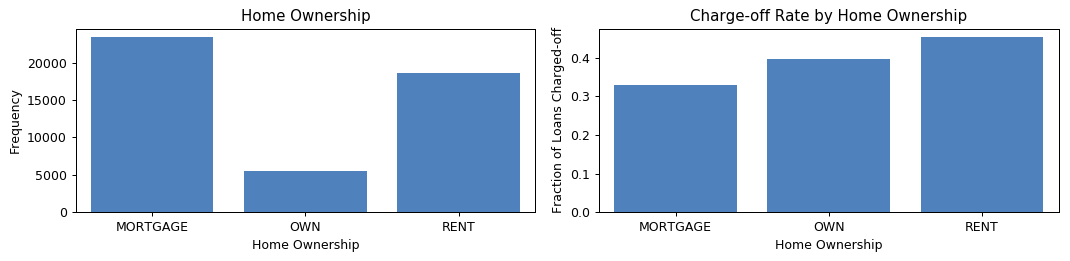

In [165]:
# dataset['home_ownership'].replace(['NONE', 'ANY'], 'NaN', inplace=True)
print(dataset.groupby('loan_status')['home_ownership'].value_counts(dropna=False))
plot_var('home_ownership', 'Home Ownership', continuous=False, dataset=dataset)
# dataset['home_ownership'].replace('NaN', np.nan, inplace=True)

Interestingly those with a mortgage are more likely to pay off loans and those who rent are the least likely

### Initial List Status (Categorical)
The initial listing status of the loan. Possible values are – W, F

loan_status  initial_list_status
Charged Off  w                      12414
             f                       5925
Fully Paid   w                      21390
             f                       7755
Name: initial_list_status, dtype: int64


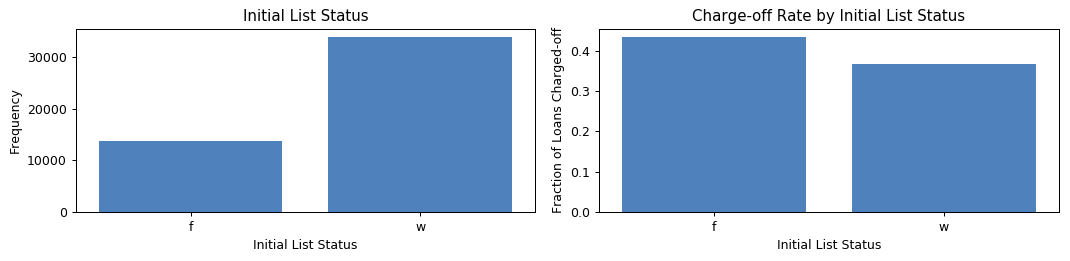

In [166]:
print(dataset.groupby('loan_status')['initial_list_status'].value_counts(dropna=False))
plot_var('initial_list_status', 'Initial List Status', continuous=False, dataset=dataset)

Theres does not seem to be much information gained from Initial List status

### Installment (Numerical)
The monthly payment owed by the borrower if the loan originates.

               count        mean         std    min     25%     50%     75%  \
loan_status                                                                   
Charged Off  18339.0  490.505433  298.951791  30.99  271.45  410.56  659.43   
Fully Paid   29145.0  420.773546  281.422908  30.12  212.75  341.41  559.44   

                 max  
loan_status           
Charged Off  1566.80  
Fully Paid   1587.23  
               count      mean       std       min       25%       50%  \
loan_status                                                              
Charged Off  18339.0  5.995893  0.676508  3.465423  5.607455  6.019955   
Fully Paid   29145.0  5.811583  0.722315  3.437851  5.364807  5.836009   

                  75%       max  
loan_status                      
Charged Off  6.492891  7.357429  
Fully Paid   6.328722  7.370375  


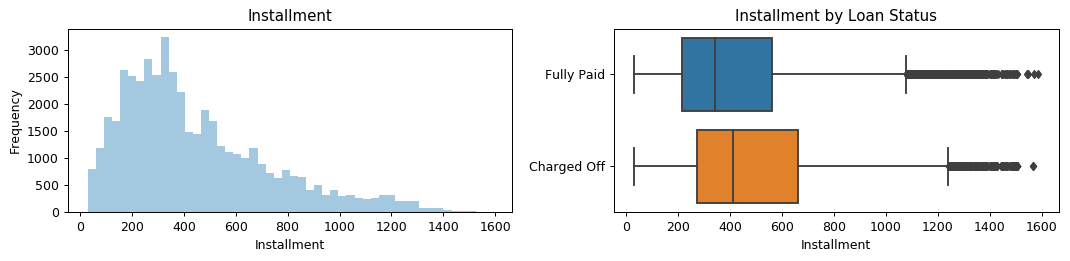

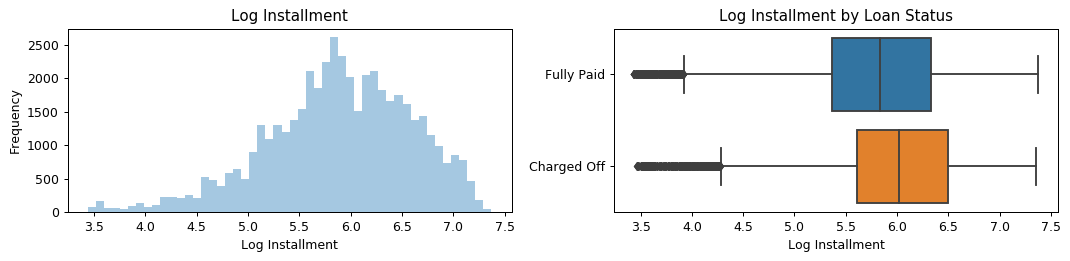

In [167]:
print(dataset.groupby('loan_status')['installment'].describe())
plot_var('installment', 'Installment', continuous=True, dataset=dataset)
# since the plot is left skewed, we take the log transformation
dataset['log_installment'] = dataset['installment'].apply(lambda x: np.log(x + 1))
dataset.drop('installment', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_installment'].describe())
plot_var('log_installment', 'Log Installment', continuous=True, dataset=dataset)

It seems those with higher installments are more likely to be charged off

### Interest Rate (Numerical)
Interest Rate on the loan

               count       mean       std   min    25%    50%    75%    max
loan_status                                                                
Charged Off  18339.0  16.560890  5.858822  5.32  12.74  15.05  18.99  30.99
Fully Paid   29145.0  13.215077  5.276465  5.32   9.93  12.62  15.99  30.99


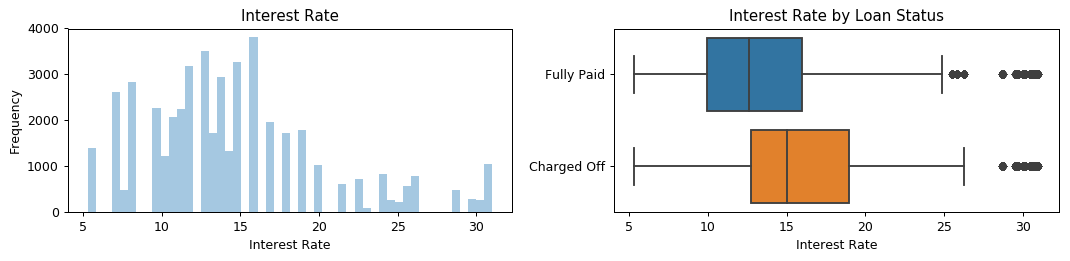

In [168]:
dataset['int_rate'] = dataset['int_rate'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['int_rate'].describe())
plot_var('int_rate', 'Interest Rate', continuous=True, dataset=dataset)

There seems to be a much higher interest rate on average for loans that charge off

### Loan Amount (Numerical)
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

               count          mean          std     min     25%      50%  \
loan_status                                                                
Charged Off  18339.0  15652.497410  9415.391819  1000.0  8000.0  14000.0   
Fully Paid   29145.0  13690.972723  9244.813927  1000.0  6400.0  11200.0   

                 75%      max  
loan_status                    
Charged Off  21000.0  40000.0  
Fully Paid   19200.0  40000.0  


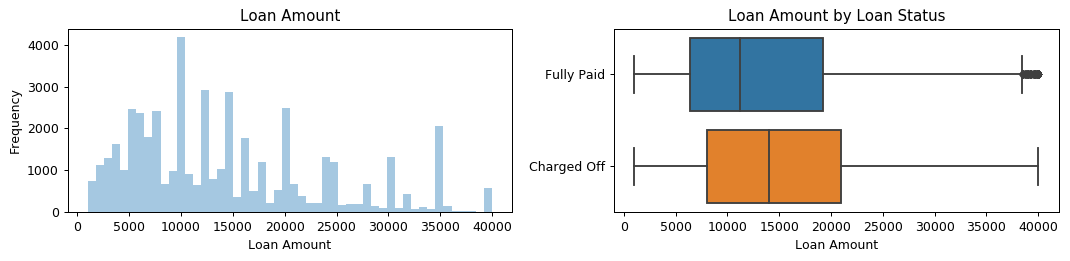

In [169]:
print(dataset.groupby('loan_status')['loan_amnt'].describe())
plot_var('loan_amnt', 'Loan Amount', continuous=True, dataset=dataset)

It seems charged off loans have a higher loan amount

### Mortgage Accounts (Numerical)
Number of mortgage accounts

loan_status  mort_acc
Charged Off  0            9006
             1            3438
             2            2495
             3            1627
             4             904
             5             471
             6             214
             7             100
             8              40
             9              28
             10             16
Fully Paid   0           11003
             1            5592
             2            4767
             3            3288
             4            2163
             5            1118
             6             608
             7             290
             8             171
             10             80
             9              65
Name: mort_acc, dtype: int64


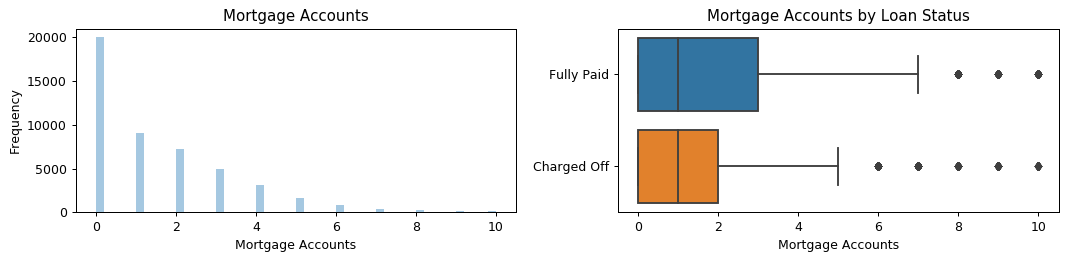

In [170]:
dataset.loc[dataset['mort_acc'] > 9, 'mort_acc'] = 10
print(dataset.groupby('loan_status')['mort_acc'].value_counts(dropna=False))
plot_var('mort_acc', 'Mortgage Accounts', continuous=True, dataset=dataset)

Currently there does not seem to be a significant difference

### Open Account (Numerical)
The number of open credit lines in the borrower's credit file.

               count       mean       std  min  25%   50%   75%   max
loan_status                                                          
Charged Off  18339.0  11.947271  5.771383  1.0  8.0  11.0  15.0  68.0
Fully Paid   29145.0  11.825630  5.743959  0.0  8.0  11.0  15.0  88.0


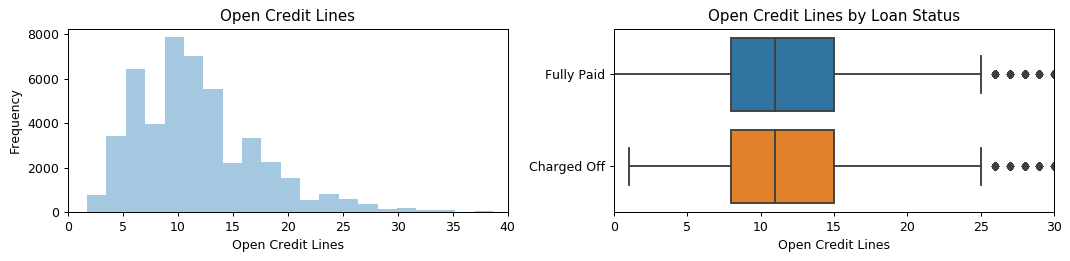

In [171]:
print(dataset.groupby('loan_status')['open_acc'].describe())
plot_var('open_acc', 'Open Credit Lines', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=30)

Does not seem to be a good indicator of risk

### Public Record (Categorical)
Number of derogatory public records

loan_status  pub_rec     
Charged Off  None            14132
             At least one     4207
Fully Paid   None            22937
             At least one     6208
Name: pub_rec, dtype: int64


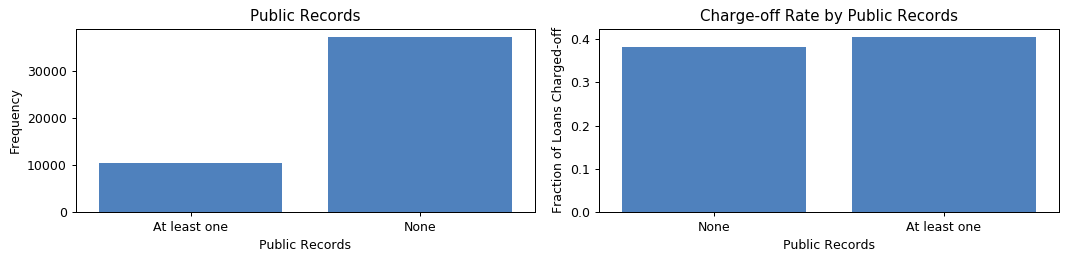

In [172]:
dataset['pub_rec'] = pd.cut(dataset['pub_rec'], [0, 0.9, 25], labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec'].value_counts(dropna=False))
plot_var('pub_rec', 'Public Records', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by derogatory public records

### Public Record of Bankruptcies (Categorical)
Number of public record bankruptcies

loan_status  pub_rec_bankruptcies
Charged Off  None                    15370
             At least one             2969
Fully Paid   None                    24732
             At least one             4413
Name: pub_rec_bankruptcies, dtype: int64


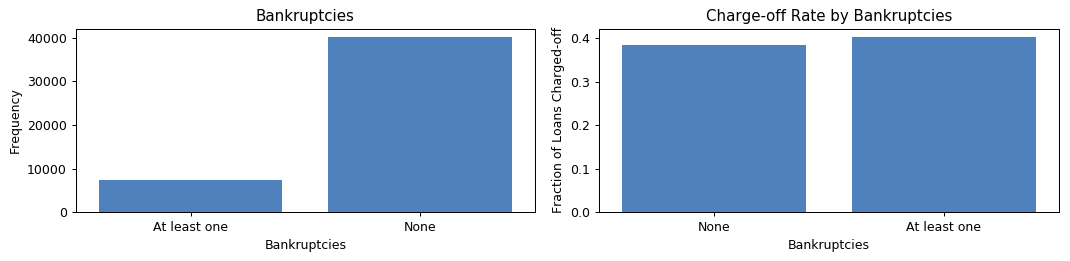

In [173]:
dataset['pub_rec_bankruptcies'] = pd.cut(dataset['pub_rec_bankruptcies'], [0, 0.9, 25], labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec_bankruptcies'].value_counts(dropna=False))
plot_var('pub_rec_bankruptcies', 'Bankruptcies', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by public bankruptcies records

### Purpose (Categorical)
A category provided by the borrower for the loan request

In [174]:
dataset.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off'].sort_values()

purpose
car                   0.291161
home_improvement      0.322494
vacation              0.329567
house                 0.332016
major_purchase        0.348673
credit_card           0.365792
other                 0.395795
debt_consolidation    0.401390
moving                0.415217
medical               0.415869
renewable_energy      0.419355
small_business        0.575526
Name: loan_status, dtype: float64

### Revolving Balance (Numerical)
Total credit revolving balance

               count          mean           std  min     25%      50%  \
loan_status                                                              
Charged Off  18339.0  15728.115546  17476.547384  0.0  6298.0  11552.0   
Fully Paid   29145.0  15601.315080  24339.574929  0.0  5176.0  10103.0   

                 75%        max  
loan_status                      
Charged Off  19446.5   354794.0  
Fully Paid   18214.0  1039013.0  
               count      mean       std  min       25%       50%       75%  \
loan_status                                                                   
Charged Off  18339.0  9.227021  1.132533  0.0  8.748146  9.354700  9.875474   
Fully Paid   29145.0  9.078444  1.308805  0.0  8.551981  9.220687  9.810001   

                   max  
loan_status             
Charged Off  12.779295  
Fully Paid   13.853783  


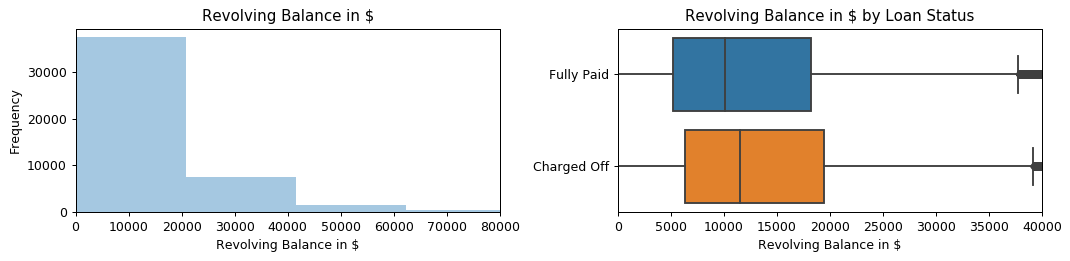

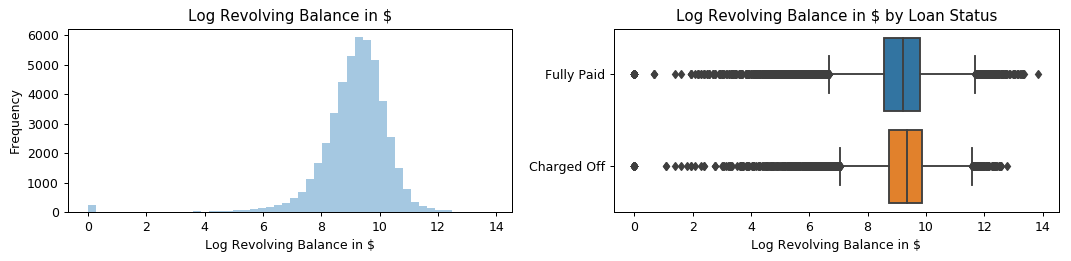

In [175]:
print(dataset.groupby('loan_status')['revol_bal'].describe())
plot_var('revol_bal', 'Revolving Balance in $', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=80000, x2l=0, x2u=40000)
# Seems like the data is heavily right skewed with a large range due to large outliers so we take the log transformation
dataset['log_revol_bal'] = dataset['revol_bal'].apply(lambda x: np.log(x + 1))
dataset.drop('revol_bal', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_revol_bal'].describe())
plot_var('log_revol_bal', 'Log Revolving Balance in $', continuous=True, dataset=dataset)

There is not much difference in the two categories for revolving balances

### Revolving Utility (Numerical)
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Charged Off  18333.0  52.649065  23.641734  0.0  35.3  52.9  70.3  138.9
Fully Paid   29120.0  44.685968  24.521824  0.0  25.4  43.3  62.9  125.2


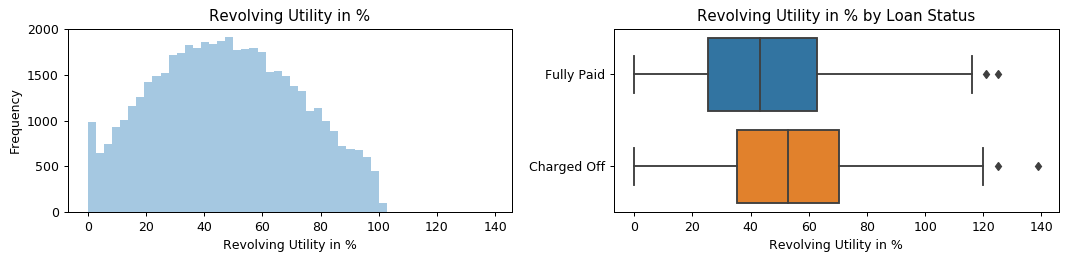

In [176]:
dataset['revol_util'] = dataset['revol_util'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['revol_util'].describe())
plot_var('revol_util', 'Revolving Utility in %', continuous=True, dataset=dataset)

It seems those with a lower revolving utility are more likely to pay off their loans

### Grade (Categorical)
LendingClub assigned loan grade. The higher the letter, the safer the loan.

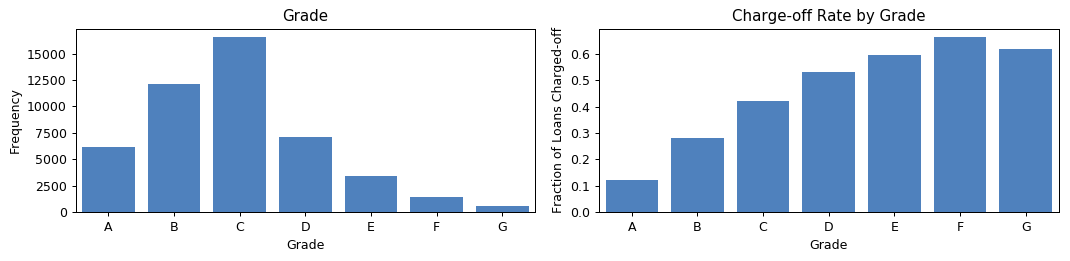

In [177]:
plot_var('grade', 'Grade', continuous=False, dataset=dataset)

There seems to be a strong trend between charge off rate and deteriorating grade

### Term (Categorical)
The number of payments on the loan. Values are in months and can be either 36 or 60

loan_status  term
Charged Off  36      12490
             60       5849
Fully Paid   36      23073
             60       6072
Name: term, dtype: int64


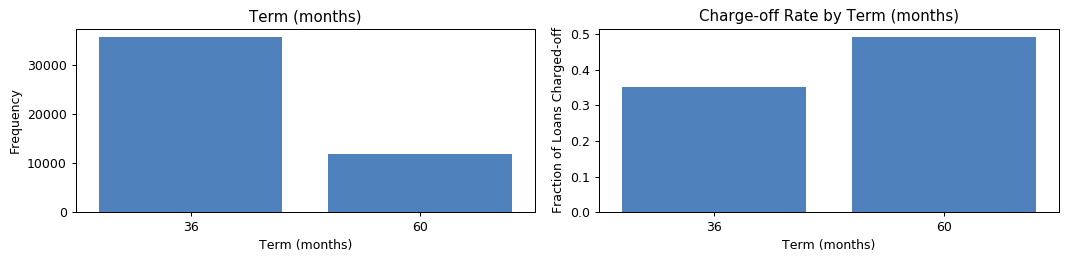

In [178]:
# dataset['term'].replace('36 months', 36, inplace=True)
# dataset['term'].replace('60 months', 60, inplace=True)
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))
print(dataset.groupby('loan_status')['term'].value_counts(dropna=False))
plot_var('term', 'Term (months)', continuous=False, dataset=dataset)

It seems longer term loans have a higher likelihood of being charged off

### Total Accounts (Numerical)
The total number of credit lines currently in the borrower's credit file

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Charged Off  18339.0  23.771362  11.849633  2.0  15.0  22.0  30.0  121.0
Fully Paid   29145.0  24.859633  12.233984  2.0  16.0  23.0  31.0  146.0


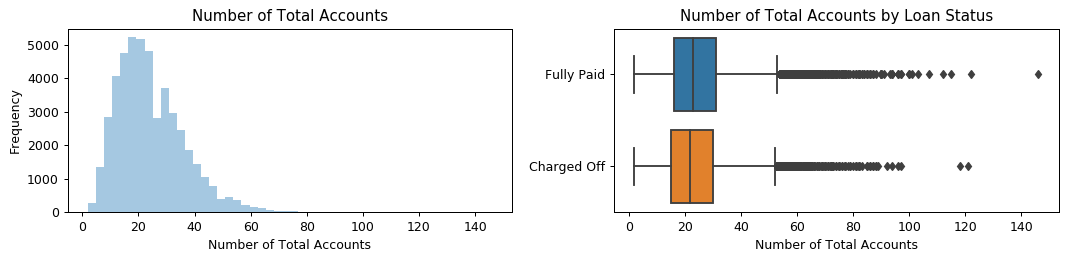

In [179]:
print(dataset.groupby('loan_status')['total_acc'].describe())
plot_var('total_acc', 'Number of Total Accounts', continuous=True, dataset=dataset)

There does not seem to be a significant difference in charge off rate depending on the total account number

### Verification Status (Categorical)
Indicates if income was verified, not verified, or if the income source was verified.

loan_status  verification_status
Charged Off  Source Verified         7487
             Verified                6712
             Not Verified            4140
Fully Paid   Source Verified        11607
             Not Verified           10330
             Verified                7208
Name: verification_status, dtype: int64


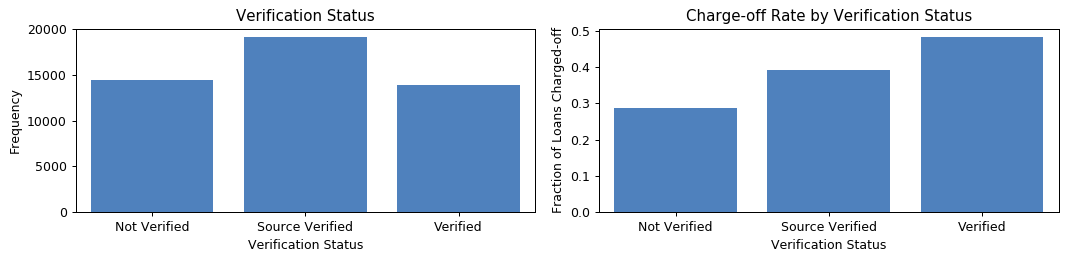

In [180]:
print(dataset.groupby('loan_status')['verification_status'].value_counts(dropna=False))
plot_var('verification_status', 'Verification Status', continuous=False, dataset=dataset)

There seems to be a strong linear trend between charged off rate and verification status. Surprisingly, loans with a status of verified have a higher chance of becoming charged off.

# Preliminary Model Design

### Create dummy variables
1 means charged-off and 0 means fully paid and create dummy variables for all categorical variables

In [181]:
dataset['loan_status'].replace('Charged Off', 1, inplace=True)
dataset['loan_status'].replace('Fully Paid', 0, inplace=True)

dataset = pd.get_dummies(dataset, columns=['grade', 'home_ownership', 'verification_status', 'purpose', 
                                           'initial_list_status', 'application_type', 'pub_rec', 'pub_rec_bankruptcies'], drop_first=True)
dataset.head()

,loan_amnt,term,int_rate,emp_length,loan_status,dti,delinq_2yrs,earliest_cr_line,open_acc,revol_util,total_acc,mort_acc,log_annual_inc,log_installment,log_revol_bal,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,pub_rec_At least one,pub_rec_bankruptcies_At least one
0,5000,36,7.35,5.0,0,15.76,0,2004,12,13.2,25,1,11.002117,5.051073,8.215547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,7500,36,7.35,7.0,0,13.12,0,2013,19,27.2,27,4,11.608245,5.454423,10.058309,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9600,36,7.97,0.0,0,18.34,0,2005,16,48.6,44,3,11.849405,5.709433,9.376617,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2000,36,7.07,2.0,0,12.15,0,2005,9,0.3,12,0,11.289794,4.140273,3.663562,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,7200,36,24.85,2.0,0,6.07,0,2000,4,98.9,5,0,10.819798,5.658436,8.177797,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


### Split the data

In [182]:
dataset.dropna(inplace=True)
# dataset.fillna(lambda x: x.median())
y = dataset.loc[:, dataset.columns == 'loan_status']
x = dataset.loc[:, dataset.columns != 'loan_status']
# y = dataset['loan_status']
# X = dataset.drop(columns=['loan_status'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=dataset['loan_status'])
# x_train = x_train.reset_index()
# y_train = y_train.reset_index()

# Feature Selection and Model Fitting

### Logistic Regression Model

In [183]:
model_lr = LogisticRegression(penalty="l2", 
                              C=0.5, 
                              fit_intercept=True, 
                              class_weight='balanced', 
                              random_state=0, 
                              max_iter=10000, 
                              solver='lbfgs')
model_lr = model_lr.fit(x_train, y_train.values.ravel())
y_pred_lr = model_lr.predict(x_test)
# df_coefs = pd.DataFrame(model.coef_[0], index=x.columns, columns = ['Coefficient'])
# df_coefs

In [184]:
print("Accuracy: %.2f%%" % (model_lr.score(x_test, y_test) * 100))
confusion_matrix(y_test, y_pred_lr)

Accuracy: 64.12%


array([[5399, 2830],
       [1910, 3070]], dtype=int64)

In [185]:
import statsmodels.api as sm
logit_model = sm.Logit(y, x)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.592150
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                    Logit                  Pseudo R-squared:       0.106     
Dependent Variable:       loan_status            AIC:                    52221.5470
Date:                     2019-06-14 13:47       BIC:                    52560.5585
No. Observations:         44029                  Log-Likelihood:         -26072.   
Df Model:                 38                     LL-Null:                -29174.   
Df Residuals:             43990                  LLR p-value:            0.0000    
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           6.0000                                                   
-----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
loan_amnt                           -0.0000   0.0000 -2.1053 0.0353 -0.0000 -0.0000
term                                 0.0141   0.0013 10.8303 0.0000  0.0116  0.0167
int_rate                             0.0111   0.0091  1.2225 0.2215 -0.0067  0.0289
emp_length                          -0.0120   0.0029 -4.0754 0.0000 -0.0177 -0.0062
dti                                  0.0117   0.0014  8.5431 0.0000  0.0090  0.0144
delinq_2yrs                          0.1479   0.0181  8.1592 0.0000  0.1124  0.1835
earliest_cr_line                    -0.0019   0.0002 -9.8715 0.0000 -0.0022 -0.0015
open_acc                             0.0245   0.0029  8.5530 0.0000  0.0189  0.0301
revol_util                           0.0086   0.0006 15.0434 0.0000  0.0075  0.0097
total_acc                           -0.0080   0.0014 -5.8506 0.0000 -0.0107 -0.0053
mort_acc                            -0.0795   0.0081 -9.8078 0.0000 -0.0953 -0.0636
log_annual_inc                      -0.1562   0.0279 -5.6035 0.0000 -0.2108 -0.1015
log_installment                      0.4307   0.0406 10.6106 0.0000  0.3512  0.5103
log_revol_bal                       -0.0271   0.0125 -2.1712 0.0299 -0.0516 -0.0026
grade_B                              0.7070   0.0573 12.3343 0.0000  0.5946  0.8193
grade_C                              1.0810   0.0793 13.6304 0.0000  0.9255  1.2364
grade_D                              1.3020   0.1143 11.3884 0.0000  1.0779  1.5261
grade_E                              1.3835   0.1669  8.2910 0.0000  1.0565  1.7106
grade_F                              1.4397   0.2150  6.6966 0.0000  1.0183  1.8611
grade_G                              1.1584   0.2338  4.9547 0.0000  0.7002  1.6167
home_ownership_OWN                   0.1731   0.0363  4.7668 0.0000  0.1020  0.2443
home_ownership_RENT                  0.3679   0.0271 13.5660 0.0000  0.3147  0.4210
verification_status_Source Verified  0.2477   0.0270  9.1580 0.0000  0.1947  0.3007
verification_status_Verified         0.3871   0.0299 12.9557 0.0000  0.3285  0.4456
purpose_credit_card                  0.1128   0.1085  1.0396 0.2985 -0.0998  0.3253
purpose_debt_consolidation           0.0892   0.1064  0.8388 0.4016 -0.1193  0.2977
purpose_home_improvement             0.2394   0.1121  2.1355 0.0327  0.0197  0.4591
purpose_house                       -0.3709   0.1855 -1.9997 0.0455 -0.7344 -0.0074
purpose_major_purchase               0.2312   0.1264  1.8299 0.0673 -0.0164  0.4789
purpose_medical                      0.4030   0.1364  2.9549 0.0031  0.1357  0.6703
purpose_moving                       0.2319   0.1497  1.5494 0.1213 -0.0614  0.5252
purpose_other                        0.2975   0.1125  2.6438 0.0082  0.0770  0.5181
purpose_renewable_energy             0.6134   0.4227  1.4512 0.1467 -0.2150  1.4417
purpose_small_business               0.8661   0.1431  6.0504 0.0000  0.5855  1.1466
purpose_vacation                     0

We remove all variables with p-value less than 0.05

In [186]:
result.pvalues[result.pvalues > 0.05]

int_rate                             0.221517
purpose_credit_card                  0.298525
purpose_debt_consolidation           0.401606
purpose_major_purchase               0.067271
purpose_moving                       0.121289
purpose_renewable_energy             0.146727
pub_rec_At least one                 0.206698
pub_rec_bankruptcies_At least one    0.584333
dtype: float64

In [187]:
keep_list = list(result.pvalues[result.pvalues < 0.05].index)
keep_list.append('loan_status')
drop_list = [col for col in dataset.columns if col not in keep_list]
x_train_lr = x_train.drop(labels=drop_list, axis=1)
x_test_lr = x_test.drop(labels=drop_list, axis=1)
model_lr2 = LogisticRegression(penalty="l2", C=0.5, fit_intercept=True, class_weight='balanced', 
                              random_state=0, max_iter=10000, solver='lbfgs')
model_lr2 = model_lr2.fit(x_train_lr, y_train.values.ravel())
y_pred_lr = model_lr2.predict(x_test_lr)

### Logistic Regression Results

In [188]:
print("Accuracy: %.2f%%" % (model_lr2.score(x_test_lr, y_test) * 100))
confusion_matrix(y_test, y_pred_lr)

Accuracy: 62.34%


array([[5116, 3113],
       [1862, 3118]], dtype=int64)

In [189]:
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

F1 Score: 0.5562394077245563
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      8229
           1       0.50      0.63      0.56      4980

   micro avg       0.62      0.62      0.62     13209
   macro avg       0.62      0.62      0.61     13209
weighted avg       0.65      0.62      0.63     13209



### Random Forest Model

In [190]:
rf_model_path = Path('../data/rf_1000.joblib')
if os.path.exists(rf_model_path):
    forest = load(rf_model_path)
else:
    n_trees = [50, 100, 250, 500, 1000, 1500, 2500]
    rf_dict = dict.fromkeys(n_trees)
    for num in n_trees:
        print(num)
        rf = RandomForestClassifier(n_estimators=num,
                                    min_samples_leaf=30,
                                    oob_score=True,
                                    random_state=100,
                                    class_weight='balanced',
                                    n_jobs=-1)
        rf.fit(x_train, y_train.values.ravel())
        rf_dict[num] = rf

    oob_error_list = [None] * len(n_trees)

    for i in range(len(n_trees)):
        oob_error_list[i] = 1 - rf_dict[n_trees[i]].oob_score_

    plt.plot(n_trees, oob_error_list, 'bo', n_trees, oob_error_list, 'k')
    # Save model to file
    dump(rf_dict[1000], rf_model_path)
    forest = rf_dict[1000]
y_pred_rf = forest.predict(x_test)

### Random Forest Results

In [191]:
print("Accuracy: %.2f%%" % (forest.score(x_test, y_test) * 100))
confusion_matrix(y_test, y_pred_rf)

Accuracy: 66.74%


array([[5690, 2539],
       [1854, 3126]], dtype=int64)

In [192]:
print('F1 Score:', f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

F1 Score: 0.58731798966651
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      8229
           1       0.55      0.63      0.59      4980

   micro avg       0.67      0.67      0.67     13209
   macro avg       0.65      0.66      0.65     13209
weighted avg       0.68      0.67      0.67     13209



In [193]:
feature_list = list(x.columns)
# Get numerical feature importances
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: int_rate             Importance: 0.23
Variable: revol_util           Importance: 0.1
Variable: dti                  Importance: 0.09
Variable: log_installment      Importance: 0.06
Variable: loan_amnt            Importance: 0.05
Variable: mort_acc             Importance: 0.05
Variable: log_annual_inc       Importance: 0.05
Variable: log_revol_bal        Importance: 0.05
Variable: total_acc            Importance: 0.04
Variable: term                 Importance: 0.03
Variable: emp_length           Importance: 0.03
Variable: earliest_cr_line     Importance: 0.03
Variable: open_acc             Importance: 0.03
Variable: grade_B              Importance: 0.03
Variable: home_ownership_RENT  Importance: 0.03
Variable: grade_C              Importance: 0.02
Variable: grade_D              Importance: 0.02
Variable: grade_E              Importance: 0.02
Variable: delinq_2yrs          Importance: 0.01
Variable: grade_F              Importance: 0.01
Variable: verification_status_Source Veri

In [194]:
# New random forest with only >= 0.05 important variables
rf_most_important = RandomForestClassifier(n_estimators=1000,
                            min_samples_leaf=30,
                            oob_score=True,
                            random_state=100,
                            class_weight='balanced',
                            n_jobs=2)
# Extract the important features
important_indices = ['int_rate', 
                     'revol_util',
                     'dti',
                     'log_installment', 
                     'loan_amnt', 
                     'mort_acc', 
                     'log_annual_inc', 
                    'log_revol_bal']
x_train_i = x_train.loc[:, important_indices]
x_test_i = x_test.loc[:, important_indices]
# Train the random forest
rf_most_important.fit(x_train_i, y_train.values.ravel())
# Make predictions and determine the error
predictions = rf_most_important.predict(x_test_i)
print("Accuracy: %.2f%%" % (rf_most_important.score(x_test_i, y_test) * 100))

Accuracy: 65.11%


### Neural Network Model

In [195]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.utils import class_weight

scaler = StandardScaler()
scaler.fit(x_train.astype('float64'))
StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_nn = scaler.transform(x_train.astype('float64'))
x_test_nn = scaler.transform(x_test.astype('float64'))
dump(scaler, Path('..\\data\\scaler.joblib'))

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train.values.ravel()), 
                                                  y_train.values.ravel())

model_nn_path = Path('../data/model_nn.h5')
if os.path.exists(model_nn_path):
    model_nn = load_model('..\\data\\model_nn.h5')
else:
    model_nn = Sequential()
    # Input layer
    model_nn.add(Dense(20, activation='relu', input_shape=(39,)))
    # Hidden layer
    model_nn.add(Dense(15, activation='relu'))
    model_nn.add(Dense(4, activation='relu'))
    # Output layer
    model_nn.add(Dense(2, activation='sigmoid'))
    model_nn.output_shape
    
    model_nn.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    model_nn.fit(x_train_nn, to_categorical(y_train), epochs=5, batch_size=10, class_weight=class_weights, verbose=1)
    
    model_nn.save('..\\data\\model_nn.h5')
y_pred_nn = model_nn.predict_classes(x_test_nn)
print(model_nn.summary())
# y_pred_nn = [round(x[0] for x in y_pred_nn)]

Epoch 1/5
30820/30820 [==============================] - 9s 288us/step - loss: 0.6103 - acc: 0.6548
Epoch 2/5
30820/30820 [==============================] - 7s 213us/step - loss: 0.5938 - acc: 0.6759
Epoch 3/5
30820/30820 [==============================] - 7s 213us/step - loss: 0.5902 - acc: 0.6804
Epoch 4/5
30820/30820 [==============================] - 7s 214us/step - loss: 0.5877 - acc: 0.6835
Epoch 5/5
30820/30820 [==============================] - 7s 218us/step - loss: 0.5856 - acc: 0.6851
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 20)                800       
_________________________________________________________________
dense_43 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 64        
______________________________________

### Neural Network Results

In [196]:
score = model_nn.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
confusion_matrix(y_test, y_pred_nn)

13209/13209 [==============================] - 1s 58us/step
Accuracy: 66.93%


array([[6847, 1382],
       [2986, 1994]], dtype=int64)

In [197]:
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

F1 Score: 0.47726184777405456
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      8229
           1       0.59      0.40      0.48      4980

   micro avg       0.67      0.67      0.67     13209
   macro avg       0.64      0.62      0.62     13209
weighted avg       0.66      0.67      0.65     13209



In [198]:
NN_probs = pd.DataFrame(model_nn.predict(x_test_nn))
print(NN_probs.head())

          0         1
0  0.369403  0.630705
1  0.860519  0.139322
2  0.417426  0.582649
3  0.662011  0.337887
4  0.478472  0.521558


In [199]:
print(x_test_nn.shape)

(13209, 39)


### XGBoost Model

In [48]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train.values.ravel()), 
                                                  y_train.values.ravel())
model_xgb = XGBClassifier(scale_pos_weight=class_weights[1]) # random state?
model_xgb.fit(x_train, y_train.values.ravel())
y_pred_xgb = model_xgb.predict(x_test)

### XGBoost Results

Accuracy: 73.38%
[[6756 1473]
 [1345 1013]]


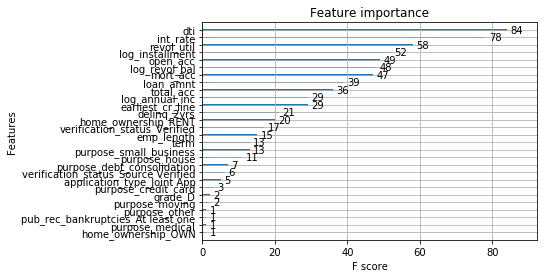

In [49]:
print("Accuracy: %.2f%%" % (model_xgb.score(x_test, y_test) * 100))
print(confusion_matrix(y_test, y_pred_xgb))
plot_importance(model_xgb)
plt.show()

In [50]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import accuracy_score
# thresholds = np.sort(model_xgb.feature_importances_)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
#     select_x_train = selection.transform(x_train)
#     # train model
#     selection_model = XGBClassifier(scale_pos_weight=class_weights[1])
#     selection_model.fit(select_x_train, y_train.values.ravel())
#     # eval model
#     select_x_test = selection.transform(x_test)
#     y_pred_xgb = selection_model.predict(select_x_test)
#     predictions = [round(value) for value in y_pred_xgb]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, 
#                                                   select_x_train.shape[1], 
#                                                   accuracy * 100))

Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.000, n=39, Accuracy: 73.38%
Thresh=0.001, n=28, Accuracy: 73.38%
Thresh=0.001, n=28, Accuracy: 73.38%
Thresh=0.001, n=28, Accuracy: 73.38%
Thresh=0.001, n=28, Accuracy: 73.38%
Thresh=0.003, n=24, Accuracy: 73.30%
Thresh=0.003, n=24, Accuracy: 73.30%
Thresh=0.004, n=22, Accuracy: 73.33%
Thresh=0.007, n=21, Accuracy: 73.32%
Thresh=0.009, n=20, Accuracy: 73.34%
Thresh=0.010, n=19, Accuracy: 73.19%
Thresh=0.016, n=18, Accuracy: 73.33%
Thresh=0.019, n=17, Accuracy: 73.08%
Thresh=0.019, n=17, Accuracy: 73.08%
Thresh=0.022, n=15, Accuracy: 73.00%
Thresh=0.025, n=14, Accuracy: 73.02%
Thresh=0.029, n=13, Accuracy: 72.95%
T

Accuracy: 72.83%
[[6709 1520]
 [1357 1001]]


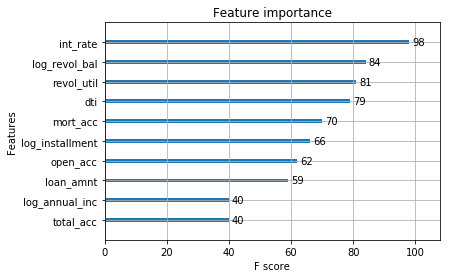

In [53]:
# Extract the ten most important features
model_path_xgb = '..\\data\\model_xgb.joblib'
if os.path.exists(model_path_xgb):
    model_xgb = load(model_path_xgb)
else:
    important_indices = ['dti', 
                         'int_rate',
                         'revol_util',
                         'log_installment', 
                         'open_acc', 
                         'log_revol_bal', 
                         'mort_acc', 
                         'loan_amnt', 
                         'total_acc',
                         'log_annual_inc']
    x_train_xgb = x_train.loc[:, important_indices]
    x_test_xgb = x_test.loc[:, important_indices]

    model_xgb = XGBClassifier(scale_pos_weight=class_weights[1])
    model_xgb.fit(x_train_xgb, y_train.values.ravel())
    y_pred_xgb = model_xgb.predict(x_test_xgb)
    print("Accuracy: %.2f%%" % (model_xgb.score(x_test_xgb, y_test) * 100))
    print(confusion_matrix(y_test, y_pred_xgb))
    plot_importance(model_xgb)
    plt.show()
    dump(model_xgb, model_path_xgb)

### Support Vector Machine Model

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model_svm_path = '..\\data\\model_svm.joblib'
if os.path.exists(model_svm_path):
    model_svm = load(model_svm_path)
else:            
#     parameter_candidates = [
#         {'C': [1, 10, 100], 'kernel': ['linear'], 'class_weight': ['balanced']},        
#         {'C': [1, 10, 100], 'gamma': [10, 0, 0.001, 0.0001], 'kernel': ['rbf'], 'class_weight': ['balanced']}    
#     ]

#     clf = GridSearchCV(estimator=SVC(), param_grid = parameter_candidates, n_jobs=-1, cv=5)
#     clf.fit(x_train, y_train.values.ravel())
#     print('Best score for data:', clf.best_score_)
#     print('Best C:', clf.best_estimator_.C)
#     print('Best Kernel:', clf.best_estimator_.kernel)
#     print('Best Gamma:', clf.best_estimator_.gamma)
    model_svm = SVC(kernel='rbf', C=1, gamma=0.05, class_weight='balanced', random_state=0)
    model_svm.fit(x_train, y_train.values.ravel())
    dump(model_svm, model_svm_path)
print('Accuracy of SVM on test set: {:.3f}'.format(model_svm.score(x_test, y_test)))
# 0.741 C=1 gamma = 0.05
# 0.777 C=1 gamma = 1

KeyboardInterrupt: 

### Ensembled Model

In [ ]:
# RF_probs = pd.DataFrame(forest.predict_proba(x_test))
# LR_probs = pd.DataFrame(lr_model.predict_proba(x_test))
# probs
ensemble_model_path = '..\\data\\ensemble_model.joblib'
if os.path.exists(ensemble_model_path):
    ensemble = load(ensemble_model_path)
else:
    estimators = [('log_reg', lr_model), ('rf', forest)]
    ensemble = VotingClassifier(estimators, voting='soft', n_jobs=-1)
    ensemble.fit(x_train, y_train.values.ravel())
    # Save model to file
    dump(ensemble, ensemble_model_path)
y_pred_ensemble = ensemble.predict(x_test)

### Ensembled Results

In [ ]:
print(confusion_matrix(y_test, y_pred_ensemble))
print('Accuracy of ensemble on test set: {:.3f}'.format(ensemble.score(x_test, y_test.values.ravel())))